In [19]:
import tempfile
import pickle as pkl
from pathlib import Path
import os
import yaml

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, KFold
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.metrics import f1_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_extraction.text import CountVectorizer

import mlflow
import dvc.api

from bayes_opt import BayesianOptimization
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns

from transformers import GPT2Tokenizer

import shap

from auxiliar import crear_ensemble_donadas

In [20]:
# Paramètres
with open("config.yml", "r", encoding="utf-8") as file:
    config = yaml.safe_load(file)

VERSION_DONADAS = config["parametres"]["version_donadas"]
LONGOR_MIN = int(config["parametres"]["longor_min"])
LONGOR_MAX = config["parametres"]["longor_max"]
if LONGOR_MAX == "inf":
    LONGOR_MAX = np.inf
TALHA_TEST = config["parametres"]["talha_test"]
ESTAT_ALEATORI = int(config["parametres"]["estat_aleatori"])

INPUT_FICHIER_WIKI_TEXTE = config["camins"]["texte"]["fichier_wiki_texte"]

if VERSION_DONADAS is not None:
    INPUT_FICHER_WIKI_ETIQUETAS_ALEATORI = dvc.api.get_url(
        config["camins"]["etiquetas"]["fichier_wiki_etiquetas_aleatori"], rev=VERSION_DONADAS
    )
    INPUT_FICHER_WIKI_ETIQUETAS_AUTOMATIC = dvc.api.get_url(
        config["camins"]["etiquetas"]["fichier_wiki_etiquetas_automatic"], rev=VERSION_DONADAS
    )
    INPUT_FICHER_WIKI_ETIQUETAS_ENTROPIA = dvc.api.get_url(
        config["camins"]["etiquetas"]["fichier_wiki_etiquetas_entropia"], rev=VERSION_DONADAS
    )
else:
    INPUT_FICHER_WIKI_ETIQUETAS_ALEATORI = config["camins"]["etiquetas"]["fichier_wiki_etiquetas_aleatori"]
    INPUT_FICHER_WIKI_ETIQUETAS_AUTOMATIC = config["camins"]["etiquetas"]["fichier_wiki_etiquetas_automatic"]
    INPUT_FICHER_WIKI_ETIQUETAS_ENTROPIA = config["camins"]["etiquetas"]["fichier_wiki_etiquetas_entropia"]

INPUT_DOSSIER_TOKENIZAIRE = config["camins"]["tokenizaire"]["dossier_tokenizaire"]

OUTPUT_PREDICCIONS = config["camins"]["classificador"]["xgboost"]["prediccions"]
OUTPUT_SELECCION_PAGINAS = config["camins"]["classificador"]["xgboost"]["seleccion_paginas"]
OUTPUT_DOSSIER_MODEL = config["camins"]["classificador"]["xgboost"]["dossier_model"]

OPTIMIZACION_BAYESIANA = False

In [21]:
texte_df = pd.read_csv(INPUT_FICHIER_WIKI_TEXTE)
longor_texte = texte_df["Texte"].apply(len)
texte_df = texte_df[(longor_texte > LONGOR_MIN) & (longor_texte < LONGOR_MAX)].reset_index(drop=True)

dict_dialectes_df = {
    "aleatori": pd.read_csv(INPUT_FICHER_WIKI_ETIQUETAS_ALEATORI),
    "entropia": pd.read_csv(INPUT_FICHER_WIKI_ETIQUETAS_ENTROPIA),
    "automatic": pd.read_csv(INPUT_FICHER_WIKI_ETIQUETAS_AUTOMATIC),
}

texte_etiquetas_df = crear_ensemble_donadas(
    texte_df=texte_df,
    dict_dialectes_df=dict_dialectes_df,
)
texte_etiquetas_df

,Article,Dialecte,Texte
0,Vieux-Champagne,lengadocian,vieux-champagne es una situada dins lo de sèin...
1,Ereditat,lengadocian,lereditat (del latin hereditas çò que s'erita ...
2,White_Town,lengadocian,white town es un projècte britanic de musica e...
3,Puigverd_d'Agramunt,lengadocian,puigverd d'agramunt es un de la
4,La_Grande_Montagne,lengadocian,la grande montagne es una de sant bartomieu di...
...,...,...,...
8359,Roger_de_Flor,provençal,ruggero da fiore ò rutger von blum (vèrs 1267 ...
8360,Aurelian_(emperaire_roman),provençal,aurelian en latin: lucius domitius aurelianus ...
8361,Miranda_(Gers),gascon,miranda (mirande en ) qu'ei ua ancianas ?
8362,Lekunberri_(Baisha_Navarra),gascon,lekunberri (


In [22]:
metadata = {
    **{
        "version_donadas": VERSION_DONADAS,
        "md5_etiquetas_aleatori": INPUT_FICHER_WIKI_ETIQUETAS_ALEATORI.split("/")[-1],
        "md5_etiquetas_automatic": INPUT_FICHER_WIKI_ETIQUETAS_AUTOMATIC.split("/")[-1],
        "md5_etiquetas_entropia": INPUT_FICHER_WIKI_ETIQUETAS_ENTROPIA.split("/")[-1],
        "talha_test": TALHA_TEST,
        "longor_min": LONGOR_MIN,
        "longor_max": LONGOR_MAX,
        "optimizacion_bayesiana": OPTIMIZACION_BAYESIANA,
    },
    **{f"nrows_{k}": v.shape[0] for k, v in dict_dialectes_df.items()},
}
metadata

{'version_donadas': 'v0.1.1',
 'md5_etiquetas_aleatori': 'e533a25164a8ade494283684561047',
 'md5_etiquetas_automatic': 'fa9d05c34dcee29c42f69fc677b304',
 'md5_etiquetas_entropia': 'd5df96afda8dbaa94570b8d147183b',
 'talha_test': 0.2,
 'longor_min': 50,
 'longor_max': inf,
 'optimizacion_bayesiana': False,
 'nrows_aleatori': 624,
 'nrows_entropia': 118,
 'nrows_automatic': 8117}

In [23]:
texte_etiquetas_entrenament, texte_etiquetas_test = train_test_split(
    texte_etiquetas_df, test_size=TALHA_TEST, random_state=ESTAT_ALEATORI
)

In [24]:
# Crear sac a mots
tokenizaire = GPT2Tokenizer.from_pretrained(
    INPUT_DOSSIER_TOKENIZAIRE,
    do_lower_case=True,
)
tokens_entrenament = texte_etiquetas_entrenament["Texte"].apply(tokenizaire.tokenize).apply(lambda x: " ".join(x))
tokens_test = texte_etiquetas_test["Texte"].apply(tokenizaire.tokenize).apply(lambda x: " ".join(x))
tokens_tot = texte_df["Texte"].apply(tokenizaire.tokenize).apply(lambda x: " ".join(x))

vectorizador = CountVectorizer(min_df=30)
bow_entrenament = vectorizador.fit_transform(tokens_entrenament)
bow_test = vectorizador.transform(tokens_test)
bow_tot = vectorizador.transform(tokens_tot)

# Codificar los dialèctes
codificador_ordinal = OrdinalEncoder()
etiquetas_entrenament = codificador_ordinal.fit_transform(texte_etiquetas_entrenament[["Dialecte"]]).astype(int)
etiquetas_test = codificador_ordinal.transform(texte_etiquetas_test[["Dialecte"]]).astype(int)

In [25]:
melhor_params = {}
if OPTIMIZACION_BAYESIANA:

    def evaluar(max_depth, learning_rate, n_estimators, gamma, min_child_weight, subsample, colsample_bytree):
        kf = KFold(n_splits=3)
        f1_scores = []

        for train_index, valid_index in kf.split(bow_entrenament):

            xgb = XGBClassifier(
                max_depth=int(max_depth),
                learning_rate=learning_rate,
                n_estimators=int(n_estimators),
                gamma=gamma,
                min_child_weight=min_child_weight,
                subsample=subsample,
                colsample_bytree=colsample_bytree,
            )
            xgb.fit(
                bow_entrenament[train_index],
                etiquetas_entrenament[train_index],
                sample_weight=compute_sample_weight("balanced", etiquetas_entrenament[train_index]),
                verbose=False,
            )
            etiquetas_predichas = xgb.predict(bow_entrenament[valid_index])
            score = f1_score(etiquetas_entrenament[valid_index], etiquetas_predichas, average="macro")
            f1_scores.append(score)

        return np.mean(f1_scores)

    limits = {
        "max_depth": (3, 12),
        "learning_rate": (0.01, 0.5),
        "n_estimators": (50, 200),
        "gamma": (0, 0.5),
        "min_child_weight": (1, 10),
        "subsample": (0.5, 1),
        "colsample_bytree": (0.5, 1),
    }

    optimizaire = BayesianOptimization(f=evaluar, pbounds=limits, random_state=63, verbose=2)

    optimizaire.maximize(init_points=10, n_iter=20)

    melhor_params = optimizaire.max["params"]
    melhor_params["max_depth"] = int(melhor_params["max_depth"])
    melhor_params["n_estimators"] = int(melhor_params["n_estimators"])

Exactitud: 0.935445307830245
Precision: 0.8238723494299551
Rappel: 0.8571149479289014
F1: 0.8375793064388797


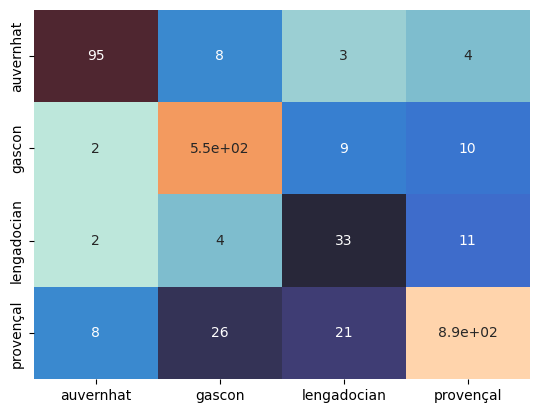

In [26]:
# Initialize MLflow
mlflow.set_experiment("XGBoost")
os.makedirs("mlruns", exist_ok=True)

# Start an MLflow run
with mlflow.start_run():

    # Entrenar e gardar lo darrièr model
    xgb_final = XGBClassifier(**melhor_params, random_state=ESTAT_ALEATORI)

    xgb_final.fit(
        bow_entrenament,
        etiquetas_entrenament,
        sample_weight=compute_sample_weight("balanced", etiquetas_entrenament),
    )
    mlflow.log_params(melhor_params)
    mlflow.log_params(metadata)

    # Predire e evaluar lo model
    y_pred_test = xgb_final.predict(bow_test).reshape(-1, 1)

    # Transformar las etiquetas numericas en etiquetas textualas
    dialecte_obs_test = codificador_ordinal.inverse_transform(etiquetas_test)
    dialecte_pred_test = codificador_ordinal.inverse_transform(y_pred_test)

    # Exactitud, Precision, Rappel, F1
    exactitud = accuracy_score(dialecte_obs_test, dialecte_pred_test)
    precision, rappel, f1, _ = precision_recall_fscore_support(
        dialecte_obs_test,
        dialecte_pred_test,
        average="macro",
    )
    print(f"Exactitud: {exactitud}\nPrecision: {precision}\nRappel: {rappel}\nF1: {f1}")
    mlflow.log_metric("exactitud", exactitud)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("rappel", rappel)
    mlflow.log_metric("f1", f1)

    # Matritz de confusion
    matritz_confusion = confusion_matrix(dialecte_obs_test, dialecte_pred_test)
    matritz_confusion_df = pd.DataFrame(
        matritz_confusion,
        index=codificador_ordinal.categories_[0],
        columns=codificador_ordinal.categories_[0],
    )
    fig = sns.heatmap(np.log(matritz_confusion_df + 1), annot=matritz_confusion_df, cbar=None, cmap="icefire")
    with tempfile.NamedTemporaryFile(suffix=".png") as temp_file:
        plt.savefig(temp_file.name)
        mlflow.log_artifact(temp_file.name, artifact_path="images")

In [27]:
with open(Path(OUTPUT_DOSSIER_MODEL) / Path("vectorizador.pkl"), "wb") as f:
    pkl.dump(vectorizador, f)

with open(Path(OUTPUT_DOSSIER_MODEL) / Path("codificador_ordinal.pkl"), "wb") as f:
    pkl.dump(codificador_ordinal, f)

with open(Path(OUTPUT_DOSSIER_MODEL) / Path("classificador.pkl"), "wb") as f:
    pkl.dump(xgb_final, f)

In [28]:
# Generar prediccions per totes los articles
y_pred_tot = xgb_final.predict(bow_tot).reshape(-1, 1)
y_prob_tot = xgb_final.predict_proba(bow_tot)
entropia_tot = np.sum(-y_prob_tot * np.log(y_prob_tot), axis=1)
resultats_df = pd.DataFrame(
    {
        "Article": texte_df["Article"],
        "Prediccion": codificador_ordinal.inverse_transform(y_pred_tot).reshape(-1),
        "Entropia": entropia_tot.reshape(-1),
    }
)
resultats_df = pd.concat(
    [resultats_df, pd.DataFrame(y_prob_tot, columns=codificador_ordinal.categories_[0])],
    axis=1,
)
resultats_df = resultats_df.merge(texte_etiquetas_df[["Article", "Dialecte"]], on="Article", how="left")
resultats_df.to_csv(OUTPUT_PREDICCIONS, index=False)
resultats_df.sort_values("Entropia", ascending=False)["Article"].to_csv(
    OUTPUT_SELECCION_PAGINAS, index=False, header=False
)
resultats_df.sort_values("Entropia", ascending=False)

,Article,Prediccion,Entropia,auvernhat,gascon,lengadocian,provençal,Dialecte
47205,Sant_Africa,gascon,1.373616,2.840241e-01,2.941677e-01,2.028083e-01,2.189998e-01,NaN
11038,Lo_Compendion_de_l'Abaco,provençal,1.371174,1.775215e-01,2.755111e-01,2.711022e-01,2.758651e-01,provençal
51945,Mont_Liban,lengadocian,1.370247,2.608315e-01,2.097238e-01,3.197705e-01,2.096741e-01,NaN
59240,Lista_d'autors_occitans,lengadocian,1.369662,2.627188e-01,2.792833e-01,2.829833e-01,1.750146e-01,NaN
599,Marols,lengadocian,1.369568,2.230211e-01,2.924015e-01,2.950155e-01,1.895618e-01,NaN
...,...,...,...,...,...,...,...,...
73382,Istòria_d'Azerbaitjan,provençal,0.000024,1.859782e-07,3.619582e-07,1.058294e-06,9.999985e-01,provençal
38287,Eudimorphodon,gascon,0.000023,6.192091e-08,9.999985e-01,2.897116e-07,1.194844e-06,NaN
75943,Juan_Manuel_de_Rosas,gascon,0.000021,1.439691e-07,9.999987e-01,5.016492e-07,7.061055e-07,gascon
28199,Mandolina,gascon,0.000016,4.568159e-08,9.999989e-01,5.344151e-07,4.512603e-07,gascon


<Axes: xlabel='Prediccion', ylabel='Entropia'>

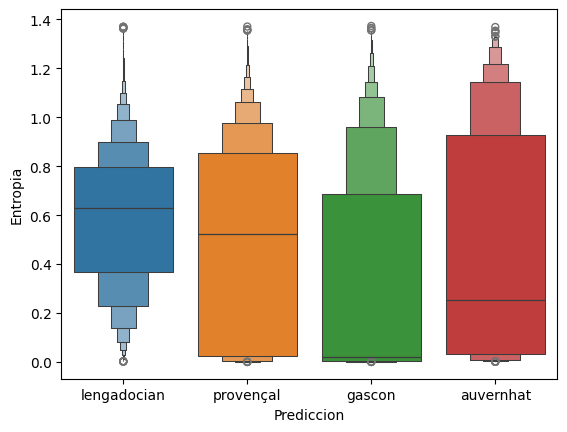

In [29]:
sns.boxenplot(data=resultats_df, x="Prediccion", y="Entropia", hue="Prediccion")

In [30]:
resultats_df.query('Dialecte.isnull() & Prediccion == "lengadocian"').sort_values("Entropia", ascending=False).head(20)

,Article,Prediccion,Entropia,auvernhat,gascon,lengadocian,provençal,Dialecte
51945,Mont_Liban,lengadocian,1.370247,0.260831,0.209724,0.319771,0.209674,NaN
59240,Lista_d'autors_occitans,lengadocian,1.369662,0.262719,0.279283,0.282983,0.175015,NaN
599,Marols,lengadocian,1.369568,0.223021,0.292402,0.295016,0.189562,NaN
3149,Charles_Albanèl,lengadocian,1.364225,0.256123,0.166421,0.299845,0.277611,NaN
63428,Portulaca_oleracea,lengadocian,1.363698,0.178508,0.227616,0.320610,0.273266,NaN
29511,Kim_Kay,lengadocian,1.362171,0.193159,0.199808,0.320733,0.286300,NaN
42516,Mohammed_VI_de_Marròc,lengadocian,1.348217,0.157060,0.231739,0.348071,0.263130,NaN
9383,Sirvens_sui,lengadocian,1.346690,0.148276,0.285624,0.332614,0.233487,NaN
61961,Carluç,lengadocian,1.343802,0.202975,0.193211,0.380430,0.223385,NaN
44365,Fontaine-sur-Somme,lengadocian,1.343017,0.185486,0.169749,0.333865,0.310900,NaN


In [31]:
resultats_df.query('Dialecte.isnull() & Prediccion == "auvernhat"').sort_values("Entropia", ascending=False).tail(20)

,Article,Prediccion,Entropia,auvernhat,gascon,lengadocian,provençal,Dialecte
13603,Api_salvatge,auvernhat,0.075409,0.987985,0.005767,0.000622,0.005625,NaN
58256,Rhinolophinae,auvernhat,0.075385,0.986974,0.001797,0.011107,0.000122,NaN
74802,Grope_dau_Recampament_Democratic_e_Sociau_Europèu,auvernhat,0.066694,0.989703,0.001726,0.002020,0.006551,NaN
32317,Sent_Jòrdi_(Gers),auvernhat,0.064470,0.988651,0.010768,0.000568,0.000013,NaN
66685,Juan_Gris,auvernhat,0.060108,0.991184,0.002645,0.003456,0.002715,NaN
6292,James_Lovelock,auvernhat,0.058043,0.991038,0.006564,0.001206,0.001192,NaN
66979,Lista_de_las_ancianas_comunas_de_Gironda,auvernhat,0.056480,0.991053,0.007009,0.000226,0.001713,NaN
34000,Sainte-Marie_(Martinica),auvernhat,0.054961,0.991955,0.001351,0.004015,0.002680,NaN
35112,Phocoena_sinus,auvernhat,0.042723,0.994054,0.002690,0.001840,0.001415,NaN
66146,Juèsa,auvernhat,0.042392,0.993919,0.003874,0.000626,0.001581,NaN


In [32]:
texte_etiquetas_df.groupby("Dialecte")["Article"].count()

Dialecte
auvernhat       515
gascon         2848
lengadocian     219
provençal      4782
Name: Article, dtype: int64

In [33]:
resultats_df.groupby("Prediccion")["Article"].count()

Prediccion
auvernhat        797
gascon          9347
lengadocian    52304
provençal      19160
Name: Article, dtype: int64

In [34]:
# explicador = shap.TreeExplainer(xgb_final)
# shap_df = pd.DataFrame(explicador(bow_test), index=texte_etiquetas_test["Article"], columns=vocab_list)

In [35]:
vocab = {v: k for k, v in vectorizador.vocabulary_.items()}
vocab_list = [vocab[i] for i in range(len(vocab))]

fi_df = pd.DataFrame({"FI": xgb_final.feature_importances_})
fi_df["TokenIndex"] = list(range(0, fi_df.shape[0]))
fi_df["Token"] = fi_df["TokenIndex"].map(lambda x: vocab[x])
fi_df = fi_df.sort_values("FI", ascending=False)
fi_df.head(60)

,FI,TokenIndex,Token
3223,0.096657,3223,ġua
1786,0.071544,1786,ġdei
443,0.036433,443,es
1840,0.032576,1840,ġdeu
1761,0.029620,1761,ġdau
1789,0.022124,1789,ġdels
2292,0.018415,2292,ġlei
3105,0.013934,3105,ġsuccã
2296,0.013237,2296,ġlengas
2862,0.011874,2862,ġquimia


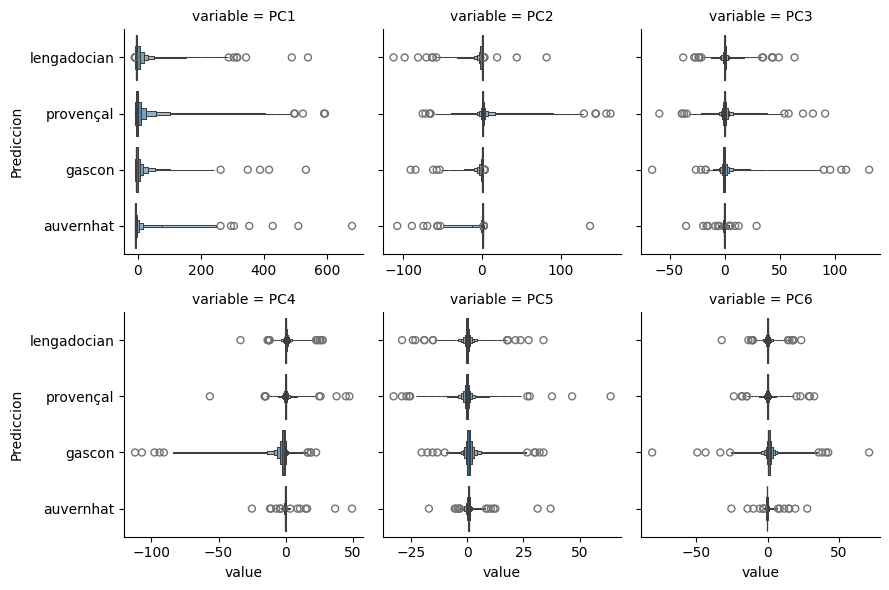

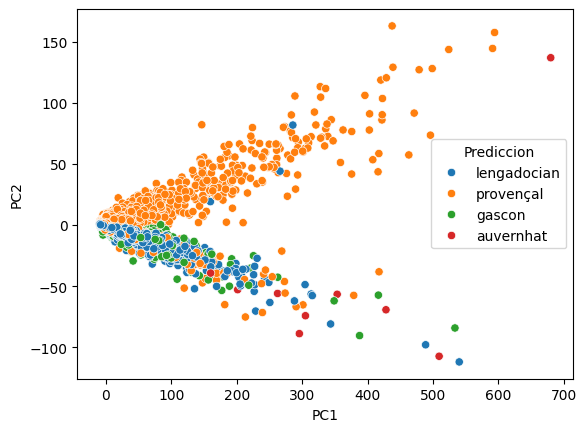

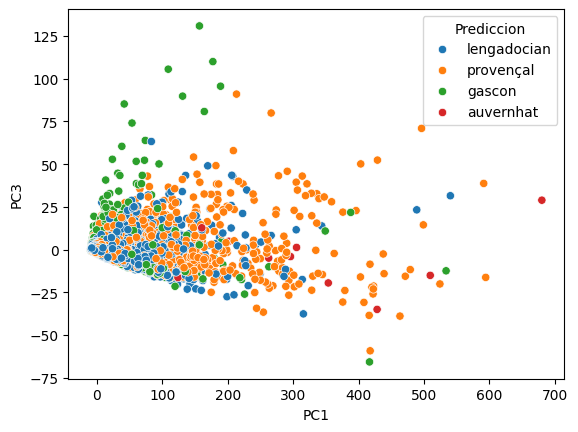

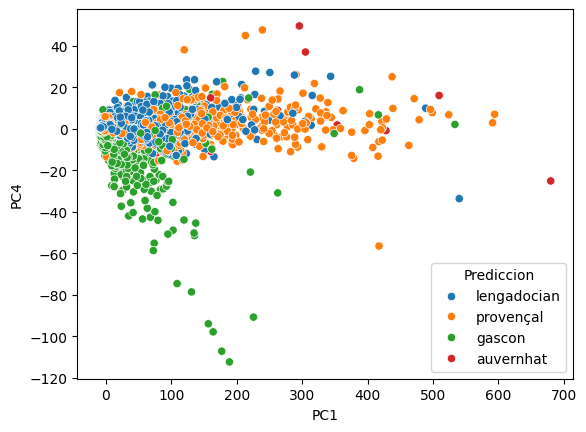

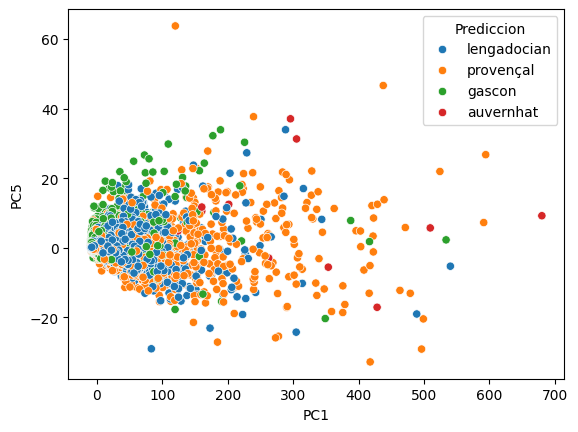

In [36]:
from sklearn.decomposition import PCA
tokens_importants = (fi_df["TokenIndex"].head(50)).to_list()

pca = PCA(n_components=6)
pca_out = pca.fit_transform(bow_tot[:,tokens_importants])
pca_df = pd.DataFrame(pca_out, columns=[f"PC{i+1}" for i in range(pca_out.shape[1])])
pca_df["Article"] = texte_df["Article"]
pca_df = pca_df.merge(resultats_df[["Article", "Prediccion"]], on="Article", how="left")
mlt_pca_df = pca_df.melt(id_vars=["Prediccion", "Article"])

g = sns.FacetGrid(data=mlt_pca_df, col="variable", col_wrap=3, sharex=False)
g.map_dataframe(sns.boxenplot, y="Prediccion", x="value")
plt.show()

sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Prediccion")
plt.show()

sns.scatterplot(data=pca_df, x="PC1", y="PC3", hue="Prediccion")
plt.show()

sns.scatterplot(data=pca_df, x="PC1", y="PC4", hue="Prediccion")
plt.show()

sns.scatterplot(data=pca_df, x="PC1", y="PC5", hue="Prediccion")
plt.show()